# Question 4

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import h5py # to be able to use v7.3 .mat files in Python
from scipy.spatial.distance import cdist # Python equivalent of pdist2
from scipy.optimize import bisect

/Users/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with h5py.File('hw4_data3.mat', 'r') as file:
    data_keys = list(file.keys())

data_ = dict()
with h5py.File('hw4_data3.mat', 'r') as file:
    for key in data_keys:
        data_[key] = np.array(file[key])
        print('Shape of the data associated with %s:' % key,
              np.shape(data_[key]), '\n')

Shape of the data associated with stype: (181, 1) 

Shape of the data associated with vresp: (1626, 181) 



In [3]:
# QUESTION 2
print('QUESTION 2')

QUESTION 2


In [4]:
stype = np.array(data_['stype'])
vresp = np.array(data_['vresp']).T

In [5]:
# PART A
print('PART A')

PART A


In [6]:
# Compute similarity matrix using euclidean distance
sim_euclidean = cdist(vresp, vresp, metric='euclidean')

In [7]:
def cmdscale(D):
    """
    Implementation of the classical multidimensional scaling (MDS) algorithm.
    Args:
        D: The symmetric matrix containing the distances between n 
            objects in p dimensions
    Returns:
        X: Coordinates of n objects in 2 dimensions
    """
    N = D.shape[0]
    # Double centering procedure
    J = np.eye(N) - np.ones((N, N)) / N
    B = - J.dot(D ** 2).dot(J) / 2 # = X.X^T
    # Diagonalization
    evals, evecs = np.linalg.eigh(B)
    # Sort eigenpairs according to the descending order of eigenvalues                                               
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    # Extract the positive eigenvalues 
    pos_idx = np.where(evals > 0)[0]
    L = np.diag(np.sqrt(evals[pos_idx]))
    E = evecs[:, pos_idx]
    X = E.dot(L)
    return X

In [8]:
# Run classical MDS
MDS_euclidean = cmdscale(sim_euclidean)

In [9]:
# Get the projections onto the first two MDS components
X_euclidean = MDS_euclidean[:, 0:2]

In [10]:
FACE_INDICES = np.where(stype == 1)[0]
BUILDING_INDICES = np.where(stype == 2)[0]

In [11]:
# Separate data with different labels
X_face_euclidean = X_euclidean[FACE_INDICES]
X_building_euclidean = X_euclidean[BUILDING_INDICES]

In [12]:
def compute_class_means(data, labels, num_classes):
    """
    Computes the mean of each class.
    Args:
        data: The input data
        labels: The given classes of each data point
        num_classes: Number of classes
    Returns:
        means: Means of the classes
    """
    means = []
    for i in range(num_classes):
        class_idx = np.where(labels == i)[0]
        means.append(np.mean(data[class_idx], axis=0))
    return np.array(means)

In [13]:
def compute_cov(data, labels, class_means):
    """
    Computes an unbiased estimator for the common covariance matrix.
    Args
        data: The input data
        labels: The given classes of each data point
        class_means: Means of the classes
    Returns:
        cov: Unbiased estimator for the common covariance matrix
    """
    K = np.size(class_means) # number of classes
    N, F = data.shape
    cov = np.zeros((F, F))
    for k in range(K):
        for x_i in data[np.where(labels == k)[0]]:
            cov += x_i.reshape(-1, 1).dot(x_i.reshape(-1, 1).T)
    cov /= (N - K)
    return cov

In [14]:
def LDA_predictor(x, cov, mean_k, k, labels):
    """
    Computes the class discriminant.
    Args:
        x: The input data point 
        cov: Covariance matrix of the data
        mean_k: Mean of the input class
        k: The input class
        labels: The input data labels
    Returns:
        delta: Class discriminant
    """
    # Compute the prior probability of class k
    pi_k = np.size(labels[labels == k]) /np.size(labels)
    if np.size(x) == 1:
        cov_inv = np.array([[1 / cov]])
    else:
        cov_inv = np.linalg.inv(cov)
    delta = np.log(pi_k) - mean_k.T.dot(cov_inv).dot(mean_k) / 2 
    delta += x.T.dot(cov_inv).dot(mean_k)
    return delta

In [15]:
def LDA_binary_boundary(data, labels):
    """
    Computes a LDA-based binary classification boundary.
    Args:
        data: The input data
        labels: The class of each data point
    Returns: 
        x_vals: x coordinate values of the linear boundary
        y_vals: y coordinate values of the linear boundary
    """
    means = compute_class_means(data, labels, 2)
    cov = compute_cov(data, labels, means)
    min_x, max_x = np.min(data[:, 0]), np.max(data[:, 0])
    min_y, max_y = np.min(data[:, 1]), np.max(data[:, 1]) 
    x_vals = np.linspace(min_x, max_x, 500) 
    y_vals = []
    for x in x_vals:
        y_vals.append(bisect(
            lambda y: LDA_predictor(np.array([x, y]), cov, means[0], 0, labels) - 
            LDA_predictor(np.array([x, y]), cov, means[1], 1, labels),
            min_y - np.sign(min_y) * 10 * min_y, max_y + np.sign(max_y) * 10 * max_y))    
    return x_vals, np.array(y_vals)

In [16]:
def LDA_classifier(x, train, labels, num_classes=2):
    """
    Computes class prediction for an input using LDA-based binary classification.
    Args:
        x: The input data point
        train: The training data
        labels: The class of each training data point
        num_classes: Number of classes in the prediction process (default is 2)
    Returns: 
        class_: Class predicted for input based on binary LDA classifier
    """
    means = compute_class_means(train, labels, num_classes)
    cov = compute_cov(train, labels, means)
    deltas = []
    for k in range(num_classes):
        deltas.append(LDA_predictor(x, cov, means[k], k, labels))
    class_ = np.argmax(np.array(deltas))
    return class_

In [17]:
x_vals_euclidean, y_vals_euclidean = LDA_binary_boundary(X_euclidean, stype - 1)

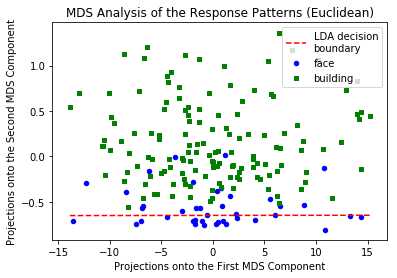

In [18]:
figure_num = 1
plt.figure(figure_num)
figure_num += 1
plt.plot(x_vals_euclidean, y_vals_euclidean, color='r', linestyle='--')
plt.scatter(X_face_euclidean[:, 0], X_face_euclidean[:, 1], s=20, marker='o', c='b')
plt.scatter(X_building_euclidean[:, 0], X_building_euclidean[:, 1], s=20, marker='s', c='g')
plt.xlabel('Projections onto the First MDS Component')
plt.ylabel('Projections onto the Second MDS Component')
plt.title('MDS Analysis of the Response Patterns (Euclidean)')
plt.legend(['LDA decision\nboundary', 'face', 'building', ])
plt.show(block=False)

In [19]:
def CV_leave_one_out(data, labels):
    """
    Performs leave one out cross validation and returns the count
    of correct classifications.
    Args:
        data: The input data
        labels: The original labels of the data points
    Returns:
        correct_count: The number of correct classifications
    """
    correct_count = 0
    for i, test in enumerate(data):
        idx = np.arange(data.shape[0]) != i
        train = data[idx]
        train_labels = labels[idx]
        class_of_test = LDA_classifier(test, train, train_labels)
        correct_count += (class_of_test == labels[i])
    return correct_count

In [20]:
N = X_euclidean.shape[0]

In [21]:
correct_count_euclidean = CV_leave_one_out(X_euclidean, stype - 1)
print('Leave one out cross validation results (euclidean):')
print('%d class labels predicted correctly out of %d' % (correct_count_euclidean, N))
print('Prediction accuracy: %.2f%%' % (100 * correct_count_euclidean / N))

Leave one out cross validation results (euclidean):
157 class labels predicted correctly out of 181
Prediction accuracy: 86.74%


In [22]:
# PART B
print('PART B')

PART B


In [23]:
# Compute similarity matrix using correlation metric
sim_correlation = cdist(vresp, vresp, metric='correlation')

In [24]:
# Run classical MDS
MDS_correlation = cmdscale(sim_correlation)

In [25]:
# Get the projections onto the first two MDS components
X_correlation = MDS_correlation[:, 0:2]
# Normalize correlation data
X_correlation[:, 0] = (X_correlation[:, 0] - np.mean(X_correlation[:, 0])) / np.std(X_correlation[:, 0])
X_correlation[:, 1] = (X_correlation[:, 1] - np.mean(X_correlation[:, 1])) / np.std(X_correlation[:, 1])

In [26]:
# Separate data with different labels
X_face_correlation = X_correlation[FACE_INDICES]
X_building_correlation = X_correlation[BUILDING_INDICES]

In [27]:
x_vals_correlation, y_vals_correlation = LDA_binary_boundary(X_correlation, stype - 1)

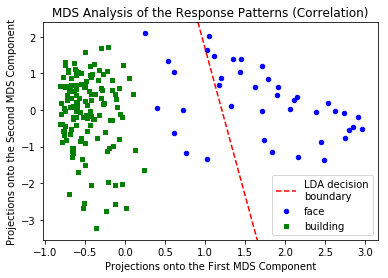

In [28]:
plt.figure(figure_num)
figure_num += 1
plt.scatter(X_face_correlation[:, 0], X_face_correlation[:, 1], s=20, marker='o', c='b')
plt.scatter(X_building_correlation[:, 0], X_building_correlation[:, 1], s=20, marker='s', c='g')
plt_axis = plt.axis()
plt.plot(x_vals_correlation, y_vals_correlation, color='r', linestyle='--')
plt.axis(plt_axis)
plt.xlabel('Projections onto the First MDS Component')
plt.ylabel('Projections onto the Second MDS Component')
plt.title('MDS Analysis of the Response Patterns (Correlation)')
plt.legend(['LDA decision\nboundary', 'face', 'building', ])
plt.show(block=False)

In [29]:
correct_count_correlation = CV_leave_one_out(X_correlation, stype - 1)
print('Leave one out cross validation results (correlation):')
print('%d class labels predicted correctly out of %d' % (correct_count_correlation, N))
print('Prediction accuracy: %.2f%%' % (100 * correct_count_correlation / N))

Leave one out cross validation results (correlation):
172 class labels predicted correctly out of 181
Prediction accuracy: 95.03%


In [30]:
# PART C
print('PART C')

PART C


In [31]:
# Test LDA classification performance on MDS representations in different dimensions
accuracies = []
for i in range(1, 6):
    X_corr = MDS_correlation[:, 0:i]
    correct_count_correlation = CV_leave_one_out(X_corr, stype - 1)
    print('Leave one out cross validation results on %d dimensional MDS representation (correlation):' % i)
    print('%d class labels predicted correctly out of %d' % (correct_count_correlation, N))
    prediction_accuracy = 100 * correct_count_correlation / N
    print('Prediction accuracy: %.2f%%\n' % prediction_accuracy)
    accuracies.append(prediction_accuracy)
accuracies = np.array(accuracies).flatten()

Leave one out cross validation results on 1 dimensional MDS representation (correlation):
168 class labels predicted correctly out of 181
Prediction accuracy: 92.82%

Leave one out cross validation results on 2 dimensional MDS representation (correlation):
172 class labels predicted correctly out of 181
Prediction accuracy: 95.03%

Leave one out cross validation results on 3 dimensional MDS representation (correlation):
170 class labels predicted correctly out of 181
Prediction accuracy: 93.92%

Leave one out cross validation results on 4 dimensional MDS representation (correlation):
170 class labels predicted correctly out of 181
Prediction accuracy: 93.92%

Leave one out cross validation results on 5 dimensional MDS representation (correlation):
170 class labels predicted correctly out of 181
Prediction accuracy: 93.92%



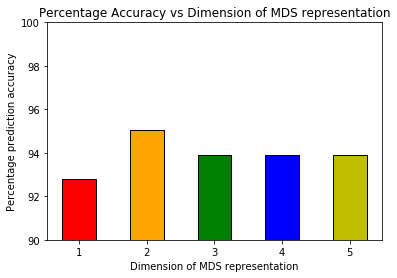

In [32]:
plt.figure(figure_num)
figure_num += 1
plt.bar(np.arange(1, 6), accuracies, width=0.5, edgecolor='black', color=['r','orange', 'g', 'b', 'y'])
plt.xlabel('Dimension of MDS representation')
plt.ylabel('Percentage prediction accuracy')
plt.title('Percentage Accuracy vs Dimension of MDS representation')
plt.ylim(90, 100)
plt.show(block=False)

In [33]:
plt.show()